# Unsupervised Learning: Autoencoders used for Anomaly Detection
Developed by Georgiy Farina, DS&AI 2nd year

## Data Setup

In [276]:
import torch
from random import randint
import numpy as np
import matplotlib.pyplot as plt

### Read main file and split into train and test

In [277]:
data = np.load('MNIST.npz')
x_train: np.ndarray = data['train_data']
x_test: np.ndarray = data['test_data']
y_train: np.ndarray = data['train_labels']
y_test: np.ndarray = data['test_labels']

normal

In [278]:
idx_eight_train = np.where(y_train[:, 8] == 1)[0]
idx_four_train = np.where(y_train[:, 4] == 1)[0]
idx_normal_train = np.where((y_train[:, 4] != 1) & (y_train[:, 8] != 1))[0]

idx_eight_test = np.where(y_test[:, 8] == 1)[0]
idx_four_test = np.where(y_test[:, 4] == 1)[0]
idx_normal_test = np.where((y_test[:, 4] != 1) & (y_test[:, 8] != 1))[0]

x_train_eight, y_train_eight = x_train[idx_eight_train], y_train[idx_eight_train]
x_train_four, y_train_four = x_train[idx_four_train], y_train[idx_four_train]
x_train_normal, y_train_normal = x_train[idx_normal_train], y_train[idx_normal_train]

x_test_eight, y_test_eight = x_test[idx_eight_test], y_test[idx_eight_test]
x_test_four, y_test_four = x_test[idx_four_test], y_test[idx_four_test]
x_test_normal, y_test_normal = x_test[idx_normal_test], y_test[idx_normal_test]


In [279]:
print('X_train_four size: ', x_train_four.shape)
print('X_train_eight size: ', x_train_eight.shape)
print('X_train_normal size: ', x_train_normal.shape)

print('Y_train_four size: ', y_train_four.shape)
print('Y_train_eight size: ', y_train_eight.shape)
print('Y_train_normal size: ', y_train_normal.shape)
print("---------------------")

print('X_test_four size: ', x_test_four.shape)
print('X_test_eight size: ', x_test_eight.shape)
print('X_test_normal size: ', x_test_normal.shape)

print('Y_test_four size: ', y_test_four.shape)
print('Y_test_eight size: ', y_test_eight.shape)
print('Y_test_normal size: ', y_test_normal.shape)

X_train_four size:  (5307, 784)
X_train_eight size:  (5389, 784)
X_train_rest size:  (44304, 784)
Y_train_four size:  (5307, 10)
Y_train_eight size:  (5389, 10)
Y_train_rest size:  (44304, 10)
---------------------
X_test_four size:  (982, 784)
X_test_eight size:  (974, 784)
X_test_rest size:  (8044, 784)
Y_test_four size:  (982, 10)
Y_test_eight size:  (974, 10)
Y_test_rest size:  (8044, 10)


## Algorithm Setup

In [280]:
# def device():
#   # This function determines whether GPU acceleration is available.
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')

In [281]:
def make_ae_model(feature_size,layer_sizes):
  # nonlinearity is hardcoded, layer_sizes should be a list of integers which
  # does not include the final (linear) layer

  layer_list = []

  current_size = feature_size
  for ls in layer_sizes:
    this_weight_layer = torch.nn.Linear(current_size,ls)
    this_nonlin_layer = torch.nn.ReLU()
    #layer_list.extend([this_weight_layer,this_nonlin_layer])
    layer_list.append(this_weight_layer)
    layer_list.append(this_nonlin_layer) # exactly the same thing
    current_size = ls

  layer_list.append(torch.nn.Linear(current_size,feature_size))

  model = torch.nn.Sequential(*layer_list)

  return model
# return model.to(device())


In [282]:
def train_ae_model(data,model, batch_size=128, max_epochs=200, lr=0.0001):
    # the model should have been created with make_ae_model, the data should have the form samples * features

    # Adam is better
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=0.0)
    #optimizer = torch.optim.SGD(model.parameters(),lr=0.7)

    epoch_losses = []
    for epoch in range(max_epochs):
        positions = np.arange(data.shape[0])
        np.random.shuffle(positions)
        batch_count = data.shape[0] // batch_size
        batches = np.array_split(positions,batch_count)
        train_losses = []

        for batch_pos,batch in enumerate(batches):
#             print('Epoch %d, batch %d' % (epoch,batch_pos))
            optimizer.zero_grad()
            this_data = data[batch]
            fwd_data = model.forward(this_data)
            loss = torch.nn.functional.mse_loss(fwd_data,this_data)

            train_losses.append(loss.detach().cpu().numpy())

            loss.backward()
            optimizer.step()
        print('Epoch %d, loss %f' % (epoch,np.mean(train_losses)))
        epoch_losses.append(np.mean(train_losses))
    return epoch_losses

In [283]:
def eval_ae_model(data,model):
    fwd_data = model.forward(data)
    loss = torch.nn.functional.mse_loss(fwd_data,data)
    return loss, fwd_data.detach().cpu().numpy()

In [317]:
def plot_single_digit(axes,data):
    data_2d = np.reshape(data,(28,28)) # if you passed in the wrong data format, this will fail
    axes.imshow(data_2d, cmap='gray')

In [285]:
def plot_train_error(axes, losses):
    axes.plot([i for i in range(len(losses))], losses, color='blue')

In [286]:
def get_images_losses(og_data, dec_data):
    errors = []
    for i in range(og_data.shape[0]):
        loss = torch.nn.functional.mse_loss(torch.tensor(og_data[i]),torch.tensor(dec_data[i]))
        errors.append(loss)
    return errors

In [287]:
def plot_images_losses(axes, losses, label, color, bins=30, alpha=1.0):
    axes.hist([x.item() for x in losses], label=label, color=color, bins=bins, alpha=alpha)
    axes.legend()

In [288]:
def get_optimal_threshold(axes, losses_normal, losses_eight):
    losses_normal_num = [x.item() for x in losses_normal]
    losses_eight_num = [x.item() for x in losses_eight]

    # Calculate TPR and FPR for each threshold value
    thresholds = np.arange(0, 1, 0.0001)
    tpr = []
    fpr = []
    f1_scores = []
    for thresh in thresholds:
        # An image is considered anomalous if its reconstruction error is above the threshold
        pred = (losses_eight_num > thresh).astype(int)
        true = np.ones_like(pred)
        tp = np.sum(np.logical_and(pred == 1, true == 1)) # true positives
        fn = np.sum(np.logical_and(pred == 0, true == 1)) # false negatives
        tpr.append(tp / (tp + fn))

        pred = (losses_normal_num > thresh).astype(int)
        true = np.zeros_like(pred)
        fp = np.sum(np.logical_and(pred == 1, true == 0)) # false positives
        tn = np.sum(np.logical_and(pred == 0, true == 0)) # true negatives
        fpr.append(fp / (fp + tn))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        if not np.isnan(f1):
            f1_scores.append(f1)
        else:
            f1_scores.append(0)

    # Plot ROC curve
    axes.plot(fpr, tpr)

    # Find threshold that maximizes TPR while minimizing FPR
    opt_idx = np.argmax(np.array(tpr) - np.array(fpr))
    axes.plot(fpr[opt_idx], tpr[opt_idx], marker='o', color='red')

    opt_thresh = thresholds[opt_idx]

    best_f1_score_idx = np.argmax(np.array(f1_scores))
    best_f1_score_threshold = thresholds[best_f1_score_idx]
    best_f1_score = f1_scores[best_f1_score_idx]

    axes.plot(fpr[best_f1_score_idx], tpr[best_f1_score_idx], marker='o', color='purple')

    print('\nWith max(tpr-fpr) threshold: ', round(opt_thresh, 3))
    print(f'\nAnomalies in EIGHT: {round(tpr[opt_idx]*100, 2)} %')
    print(f'Anomalies in Normal: {round(fpr[opt_idx]*100, 2)} %')

    print('\nThreshold maximizing f1-score: ', round(best_f1_score_threshold, 3))
    print(f'\nAnomalies in EIGHT: {round(tpr[best_f1_score_idx]*100, 2)} %')
    print(f'Anomalies in Normal: {round(fpr[best_f1_score_idx]*100, 2)} %')
    print(f'Best f1 score: {best_f1_score}')

    # Sort the points
    sorted_indices = np.argsort(fpr)
    sorted_fpr = np.array(fpr)[sorted_indices]
    sorted_tpr = np.array(tpr)[sorted_indices]

    # Calculate the area under the curve
    auc_roc = np.trapz(sorted_tpr, sorted_fpr)

    print("\nAUC-ROC:", auc_roc)

    return opt_thresh, tpr[opt_idx], fpr[opt_idx], best_f1_score, best_f1_score_threshold

In [289]:
def validate_plot_model(model, epochs_losses, plot_four=False):
    F, X = plt.subplots(1,3, figsize=(30, 8))

    fontsize = 20
    titles = ['Learning curve of the model', 'Reconstruction errors distribution', 'ROC curve']
    xlabels = ['Epoch N°', 'Reconstruction error', 'FPR']
    ylabels = ['Reconstruction loss', 'Count', 'TPR']

    plt.suptitle(f'Topology: {topology}', fontsize=fontsize*1.5)

    for i, ax in enumerate(X.flat):
        ax.set_title(titles[i], fontsize=fontsize)
        ax.set_xlabel(xlabels[i], fontsize=fontsize)
        ax.set_ylabel(ylabels[i], fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize*0.5)
        ax.tick_params(axis='y', labelsize=fontsize*0.5)

    losses = {'normal': None, 'eight': None, 'four': None}
    colors = ['red', 'yellow', 'green']
    alphas = [1.0, 0.5, 0.5]

    # DONE
    X[0].plot([i for i in range(len(epochs_losses))], epochs_losses, color='blue')

    train_mse_normal, train_dec_data_normal = eval_ae_model(torch.tensor(x_train_normal),model)
    test_mse_normal, test_dec_data_normal = eval_ae_model(torch.tensor(x_test_normal),model)
    test_mse_eight, test_dec_data_eight = eval_ae_model(torch.tensor(x_test_eight),model)


    losses_train = get_images_losses(x_train_normal, train_dec_data_normal)
    losses['normal'] = get_images_losses(x_test_normal, test_dec_data_normal)
    losses['eight'] = get_images_losses(x_test_eight, test_dec_data_eight)

    print('\nMean MSE:\n\tTrain\t->\t%f\n\tnormal\t->\t%f\n\t8\t\t->\t%f' % (train_mse_normal, test_mse_normal,test_mse_eight))

    delta_th, tpr, fpr, best_f1_score, best_f1_score_threshold = get_optimal_threshold(X[2], losses['normal'], losses['eight'])

    X[1].axvline(x=delta_th, color='black')
    X[1].axvline(x=best_f1_score_threshold, color='blue')



    if plot_four:
        test_mse_four, test_dec_data_four = eval_ae_model(torch.tensor(x_test_four),model)
        losses['four'] = get_images_losses(x_test_four, test_dec_data_four)
        print('\t4\t\t->\t%f' % test_mse_four)

    for i, (key, value) in enumerate(losses.items()):
        if value is not None:
            plot_images_losses(X[1], value, color=colors[i], label=f'Losses for test/{key}', alpha=alphas[i])
    losses['train'] = losses_train
    return losses, delta_th, tpr, fpr, best_f1_score, best_f1_score_threshold

In [290]:
def evaluate_model(model, threshold):
    test_mse_four, test_dec_data_four = eval_ae_model(torch.tensor(x_test_four),model)

    losses_four = get_images_losses(x_test_four, test_dec_data_four)

    anomaly_amount = sum([1 for num in losses_four if num > threshold]) / len(losses_four)
    print(f'Anomalies in FOUR: {round(anomaly_amount*100)} %')

In [291]:
import json

def save_model(model, topology, batch, epochs, mse_normal, mse_eight, tpr, fpr, auc, threshold):
    torch.save(model, 'best_model.pth')
    info_dict = {'topology': topology, 'batch': batch, 'epochs':epochs, 'mse':{'normal': mse_normal, '8': mse_eight}, 'tpr': tpr, 'fpr': fpr, 'auc':auc, 'threshold': threshold}
    with open('best_model_info.txt', mode='w') as file:
        json.dump(info_dict, file)

def load_model_info():
    model = torch.load('best_model.pth')

    with open('best_model_info.txt', 'r') as file:
        info_dict = json.load(file)

    topology = info_dict['topology']
    batch = info_dict['batch']
    epochs = info_dict['epochs']
    mse_normal = info_dict['mse']['normal']
    mse_eight = info_dict['mse']['8']
    tpr = info_dict['tpr']
    fpr = info_dict['fpr']
    auc = info_dict['auc']
    threshold = info_dict['threshold']

    return model, topology, batch, epochs, mse_normal, mse_eight, tpr, fpr, auc, threshold

### Optimizing the quality of the anomaly detection on test/8

#### After many experiments...

In [292]:
def experiment(n_experiment, topology, batch_size=128, max_epochs=100, lr=0.0001):
    # topology = [784, 400, 30, 400, 784]
    print(f'Experiment N° {n_experiment}')
    print('-'*50)
    model = make_ae_model(784,topology)
    epochs_losses = train_ae_model(torch.tensor(x_train_normal), model, batch_size=batch_size, max_epochs=max_epochs, lr=lr)
    train_test_losses, th, tpr, fpr, best_f1_score, best_f1_score_threshold = validate_plot_model(model, epochs_losses)
    return model, th, tpr, fpr, best_f1_score, best_f1_score_threshold

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.065265
Epoch 1, loss 0.038205
Epoch 2, loss 0.033466
Epoch 3, loss 0.031378
Epoch 4, loss 0.029966
Epoch 5, loss 0.028963
Epoch 6, loss 0.028199
Epoch 7, loss 0.027571
Epoch 8, loss 0.027051
Epoch 9, loss 0.026619
Epoch 10, loss 0.026239
Epoch 11, loss 0.025904
Epoch 12, loss 0.025617
Epoch 13, loss 0.025363
Epoch 14, loss 0.025137
Epoch 15, loss 0.024925
Epoch 16, loss 0.024739
Epoch 17, loss 0.024569
Epoch 18, loss 0.024410
Epoch 19, loss 0.024268
Epoch 20, loss 0.024126
Epoch 21, loss 0.023995
Epoch 22, loss 0.023880
Epoch 23, loss 0.023771
Epoch 24, loss 0.023664
Epoch 25, loss 0.023571
Epoch 26, loss 0.023479
Epoch 27, loss 0.023389
Epoch 28, loss 0.023308
Epoch 29, loss 0.023235
Epoch 30, loss 0.023162
Epoch 31, loss 0.023089
Epoch 32, loss 0.023022
Epoch 33, loss 0.022952
Epoch 34, loss 0.022891
Epoch 35, loss 0.022826
Epoch 36, loss 0.022763
Epoch 37, loss 0.022707
Epoch 38, loss 0.022657
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.027

Anomalies in EIGHT: 91.89 %
Anomalies in REST: 21.15 %

Threshold maximizing f1-score:  0.034

Anomalies in EIGHT: 69.1 %
Anomalies in REST: 8.47 %
Best f1 score: 0.5781786941580757

AUC-ROC: 0.9244831685483434
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.058902
Epoch 1, loss 0.034989
Epoch 2, loss 0.030107
Epoch 3, loss 0.028201
Epoch 4, loss 0.027041
Epoch 5, loss 0.026064
Epoch 6, loss 0.025061
Epoch 7, loss 0.024348
Epoch 8, loss 0.023798
Epoch 9, loss 0.023326
Epoch 10, loss 0.022902
Epoch 11, loss 0.022541
Epoch 12, loss 0.022228
Epoch 13, loss 0.021937
Epoch 14, loss 0.021682
Epoch 15, loss 0.021438
Epoch 16, loss 0.021213
Epoch 17, loss 0.021006
Epoch 18, loss 0.020816
Epoch 19, loss 0.020630
Epoch 20, loss 0.020460
Epoch 21, loss 0.020294
Epoch 22, loss 0.020138
Epoch 23, loss 0.019992
Epoch 24, loss 0.019856
Epoch 25, loss 0.019726
Epoch 26, loss 0.019597
Epoch 27, loss 0.019475
Epoch 28, loss 0.01936

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:27: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)



With max(tpr-fpr) threshold:  0.03

Anomalies in EIGHT: 98.25 %
Anomalies in REST: 12.46 %

Threshold maximizing f1-score:  0.038

Anomalies in EIGHT: 84.29 %
Anomalies in REST: 5.99 %
Best f1 score: 0.7211242863416776

AUC-ROC: 0.9663870018798048


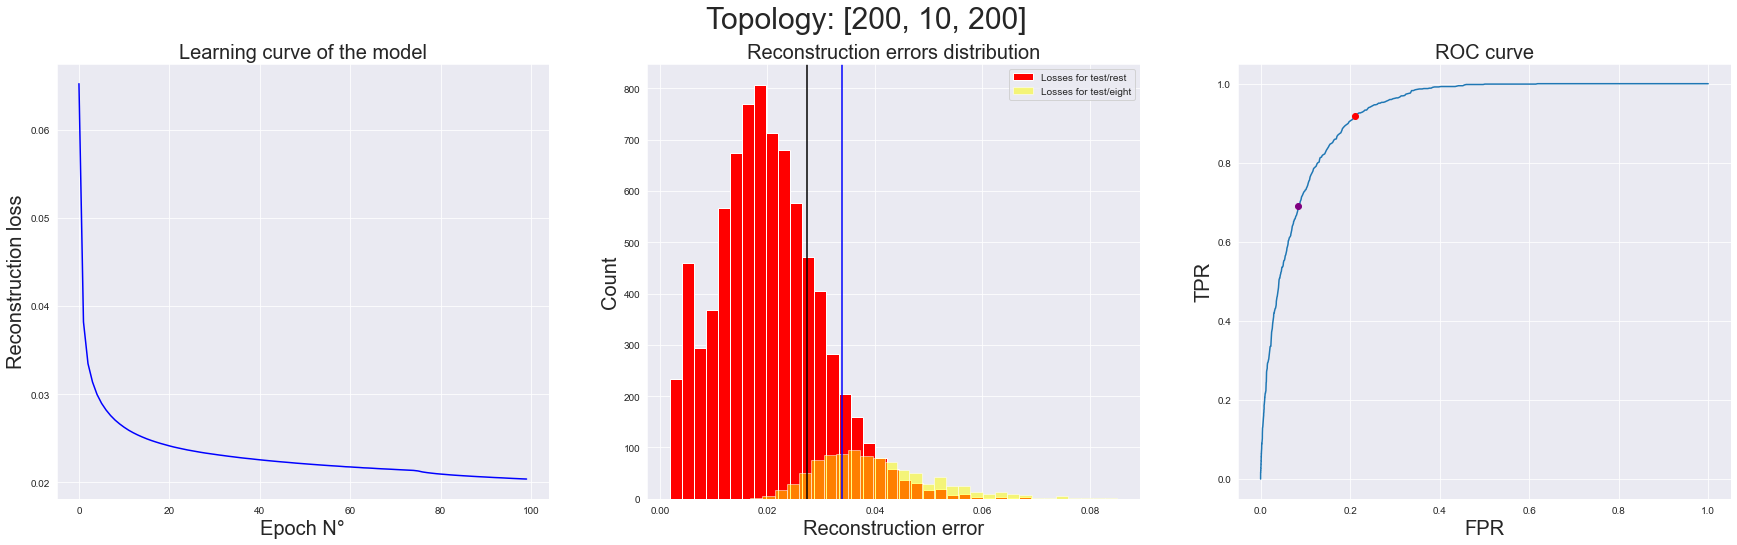

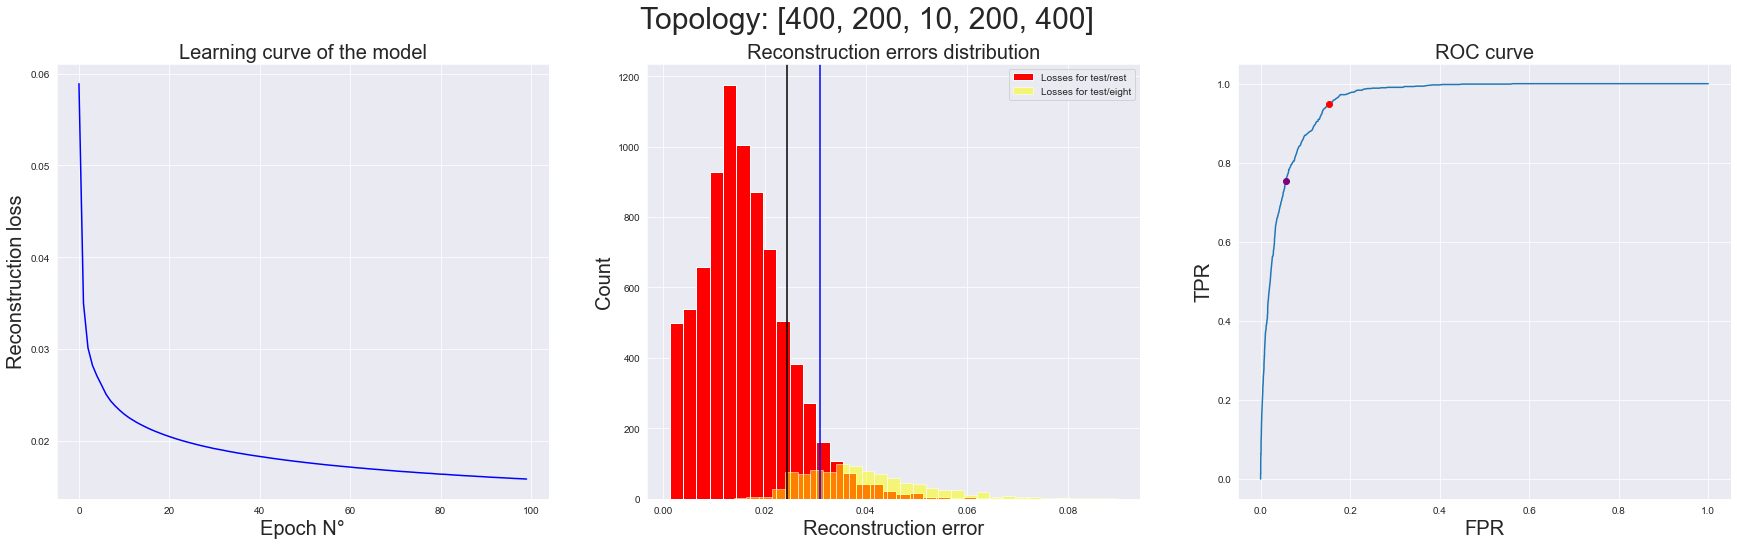

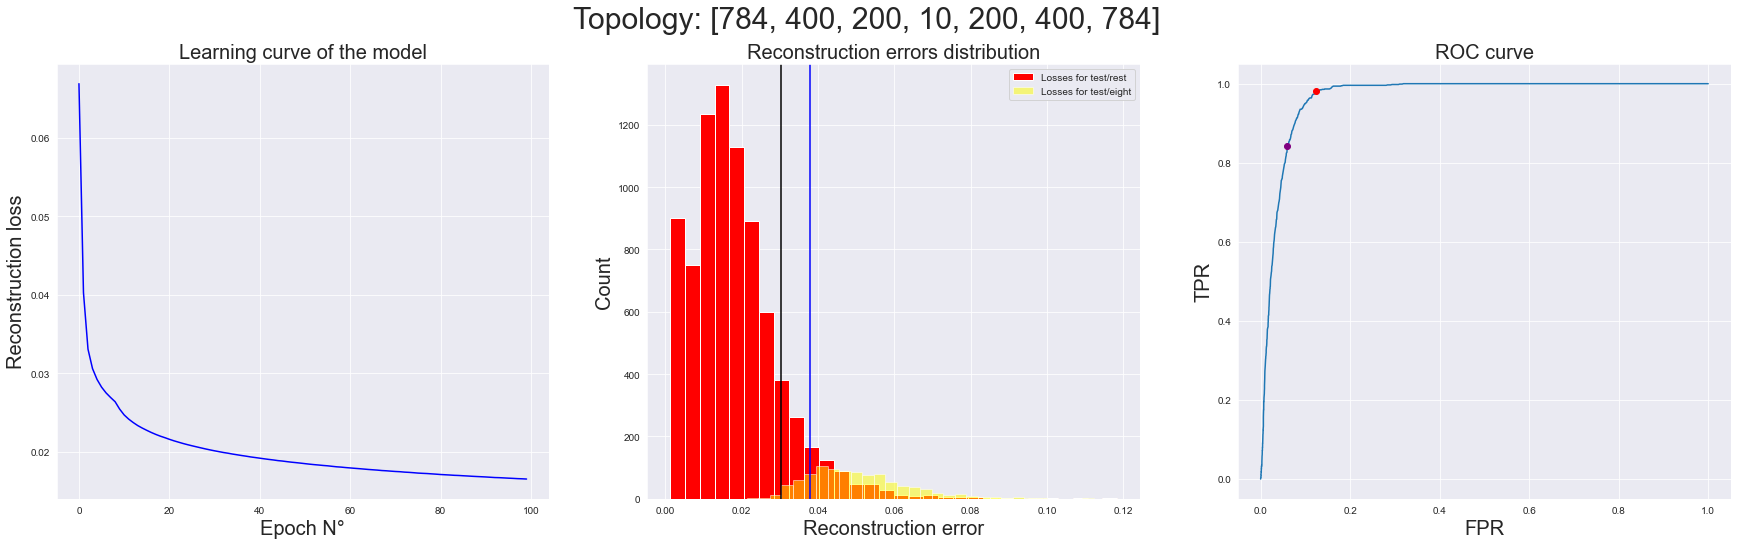

In [298]:
topologies_exp_for_n_layers = [
    [200, 10, 200],
    [400, 200, 10, 200, 400],
    [784, 400, 200, 10, 200, 400, 784]
]
best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = None, 0, -1, -1, 0, -1
for i, topology in enumerate(topologies_exp_for_n_layers):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, topology)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = topology, th, tpr, fpr, f1_score, f1_score_threshold

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.063782
Epoch 1, loss 0.039039
Epoch 2, loss 0.030617
Epoch 3, loss 0.027354
Epoch 4, loss 0.025604
Epoch 5, loss 0.024454
Epoch 6, loss 0.023608
Epoch 7, loss 0.022911
Epoch 8, loss 0.022346
Epoch 9, loss 0.021868
Epoch 10, loss 0.021475
Epoch 11, loss 0.021118
Epoch 12, loss 0.020809
Epoch 13, loss 0.020527
Epoch 14, loss 0.020272
Epoch 15, loss 0.020038
Epoch 16, loss 0.019832
Epoch 17, loss 0.019620
Epoch 18, loss 0.019447
Epoch 19, loss 0.019276
Epoch 20, loss 0.019105
Epoch 21, loss 0.018963
Epoch 22, loss 0.018821
Epoch 23, loss 0.018683
Epoch 24, loss 0.018549
Epoch 25, loss 0.018424
Epoch 26, loss 0.018308
Epoch 27, loss 0.018191
Epoch 28, loss 0.018085
Epoch 29, loss 0.017983
Epoch 30, loss 0.017887
Epoch 31, loss 0.017791
Epoch 32, loss 0.017688
Epoch 33, loss 0.017608
Epoch 34, loss 0.017520
Epoch 35, loss 0.017437
Epoch 36, loss 0.017352
Epoch 37, loss 0.017276
Epoch 38, loss 0.017200
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.024

Anomalies in EIGHT: 95.38 %
Anomalies in REST: 13.04 %

Threshold maximizing f1-score:  0.03

Anomalies in EIGHT: 81.31 %
Anomalies in REST: 6.75 %
Best f1 score: 0.6860112602858381

AUC-ROC: 0.9605473923196546
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.060795
Epoch 1, loss 0.036342
Epoch 2, loss 0.029299
Epoch 3, loss 0.026461
Epoch 4, loss 0.024663
Epoch 5, loss 0.023036
Epoch 6, loss 0.022003
Epoch 7, loss 0.021255
Epoch 8, loss 0.020685
Epoch 9, loss 0.020182
Epoch 10, loss 0.019749
Epoch 11, loss 0.019360
Epoch 12, loss 0.019015
Epoch 13, loss 0.018703
Epoch 14, loss 0.018414
Epoch 15, loss 0.018147
Epoch 16, loss 0.017899
Epoch 17, loss 0.017673
Epoch 18, loss 0.017473
Epoch 19, loss 0.017259
Epoch 20, loss 0.017077
Epoch 21, loss 0.016902
Epoch 22, loss 0.016738
Epoch 23, loss 0.016579
Epoch 24, loss 0.016435
Epoch 25, loss 0.016286
Epoch 26, loss 0.016164
Epoch 27, loss 0.016034
Epoch 28, loss 0.01590

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:27: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)



With max(tpr-fpr) threshold:  0.031

Anomalies in EIGHT: 95.59 %
Anomalies in REST: 9.81 %

Threshold maximizing f1-score:  0.04

Anomalies in EIGHT: 79.16 %
Anomalies in REST: 3.84 %
Best f1 score: 0.7507302823758519

AUC-ROC: 0.9715928410171163


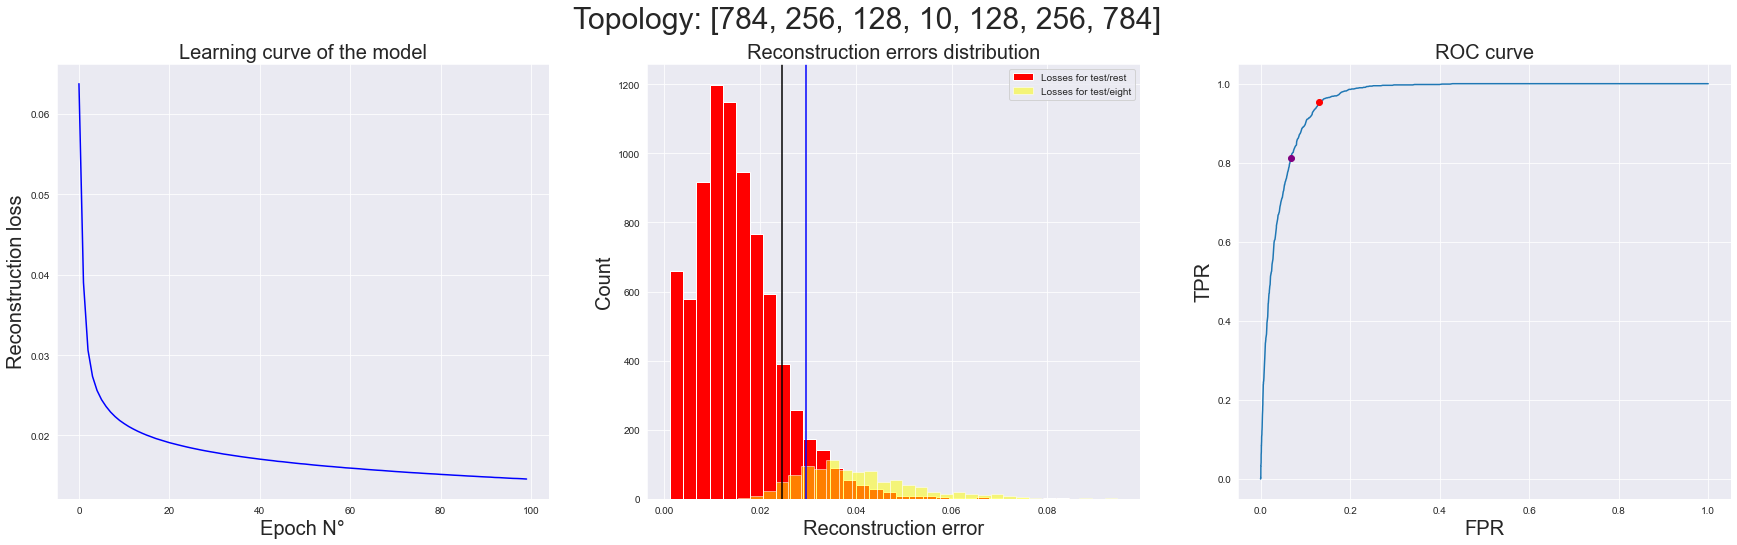

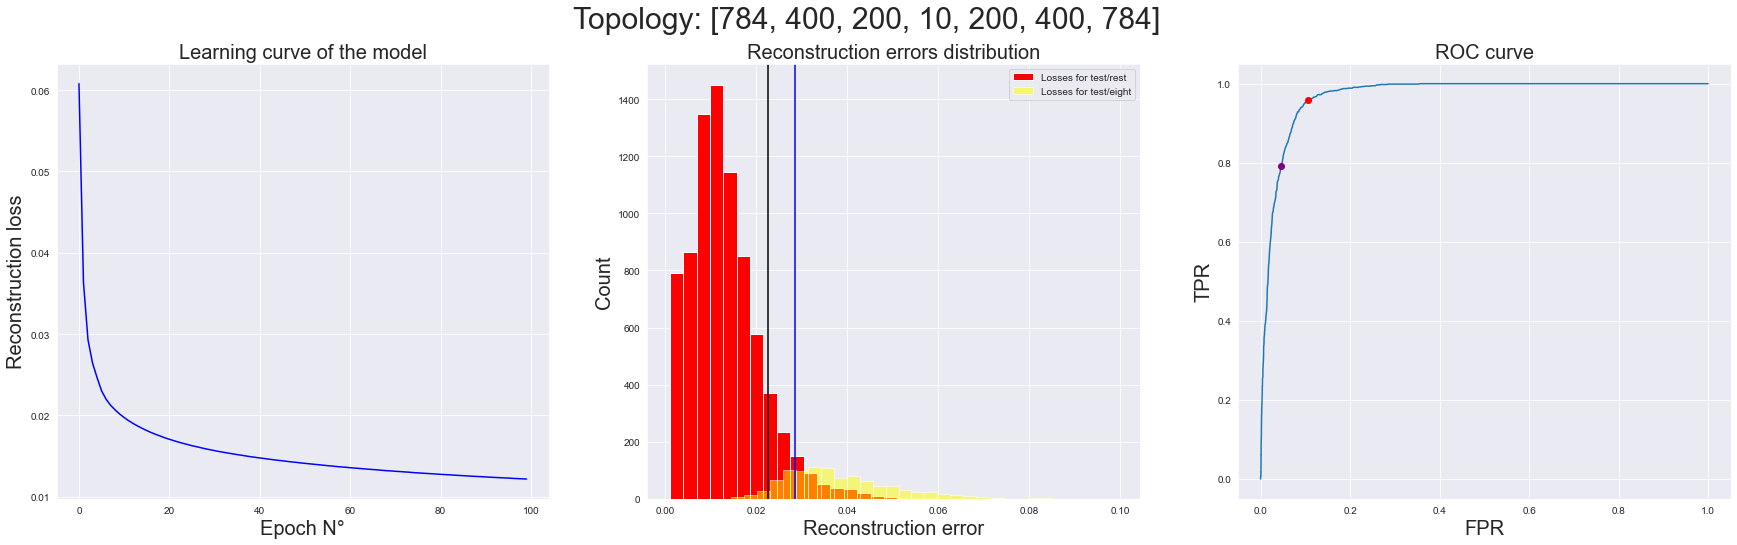

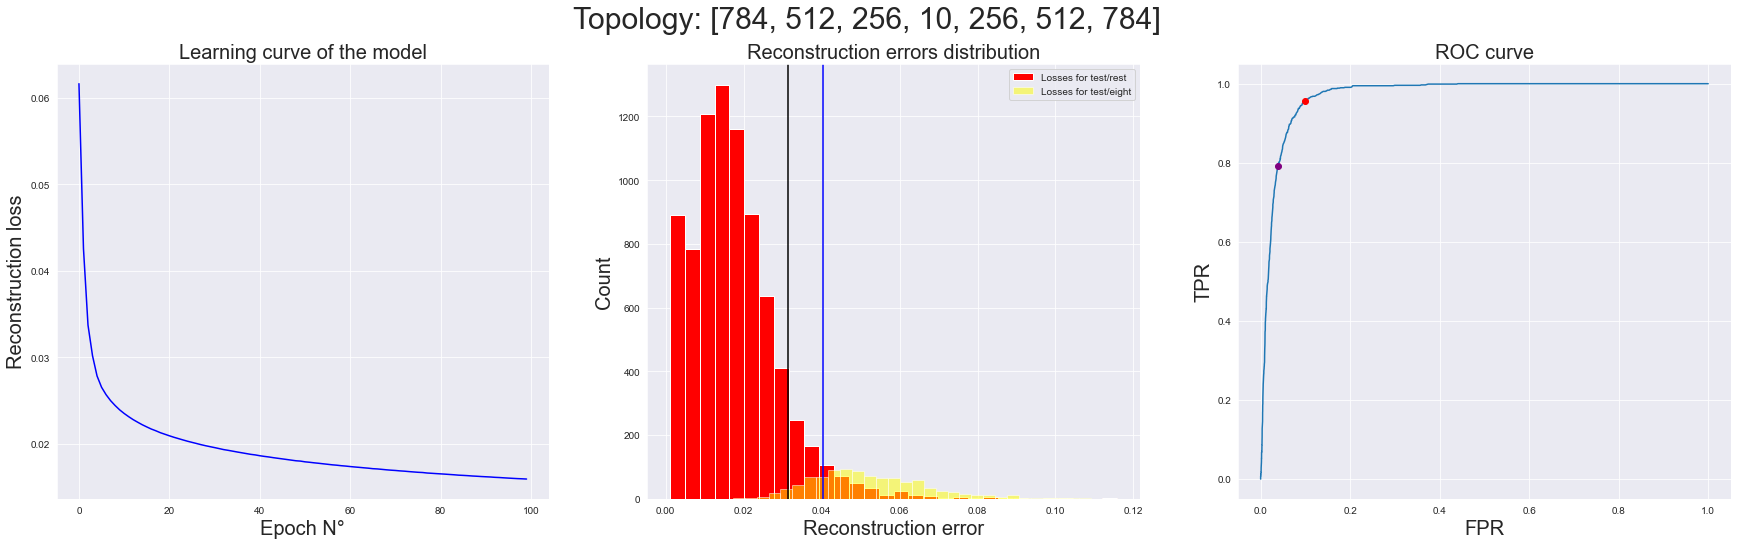

In [294]:
# BEST TOPOLOGY OBTAINED BEFORE:
topologies_exp_for_n_nodes = [
    [784, 256, 128, 10, 128, 256, 784],
    [784, 400, 200, 10, 200, 400, 784],
    [784, 512, 256, 10, 256, 512, 784]
]
for i, topology in enumerate(topologies_exp_for_n_nodes):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, topology)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = topology, th, tpr, fpr, f1_score, f1_score_threshold
#evaluate_model(model)

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.063576
Epoch 1, loss 0.052124
Epoch 2, loss 0.041309
Epoch 3, loss 0.035303
Epoch 4, loss 0.032875
Epoch 5, loss 0.031499
Epoch 6, loss 0.030537
Epoch 7, loss 0.029590
Epoch 8, loss 0.028268
Epoch 9, loss 0.027419
Epoch 10, loss 0.026681
Epoch 11, loss 0.025753
Epoch 12, loss 0.024988
Epoch 13, loss 0.024407
Epoch 14, loss 0.023908
Epoch 15, loss 0.023486
Epoch 16, loss 0.023109
Epoch 17, loss 0.022773
Epoch 18, loss 0.022450
Epoch 19, loss 0.022166
Epoch 20, loss 0.021900
Epoch 21, loss 0.021653
Epoch 22, loss 0.021426
Epoch 23, loss 0.021222
Epoch 24, loss 0.021023
Epoch 25, loss 0.020851
Epoch 26, loss 0.020675
Epoch 27, loss 0.020521
Epoch 28, loss 0.020375
Epoch 29, loss 0.020231
Epoch 30, loss 0.020096
Epoch 31, loss 0.019968
Epoch 32, loss 0.019855
Epoch 33, loss 0.019745
Epoch 34, loss 0.019630
Epoch 35, loss 0.019526
Epoch 36, loss 0.019423
Epoch 37, loss 0.019322
Epoch 38, loss 0.019220
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.032

Anomalies in EIGHT: 96.3 %
Anomalies in REST: 9.55 %

Threshold maximizing f1-score:  0.04

Anomalies in EIGHT: 84.29 %
Anomalies in REST: 4.4 %
Best f1 score: 0.764076314564914

AUC-ROC: 0.9733095285988663
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.060946
Epoch 1, loss 0.035730
Epoch 2, loss 0.028447
Epoch 3, loss 0.025337
Epoch 4, loss 0.023269
Epoch 5, loss 0.021816
Epoch 6, loss 0.020691
Epoch 7, loss 0.019756
Epoch 8, loss 0.018880
Epoch 9, loss 0.018084
Epoch 10, loss 0.017435
Epoch 11, loss 0.016883
Epoch 12, loss 0.016407
Epoch 13, loss 0.016004
Epoch 14, loss 0.015650
Epoch 15, loss 0.015331
Epoch 16, loss 0.015040
Epoch 17, loss 0.014770
Epoch 18, loss 0.014512
Epoch 19, loss 0.014261
Epoch 20, loss 0.014028
Epoch 21, loss 0.013796
Epoch 22, loss 0.013597
Epoch 23, loss 0.013399
Epoch 24, loss 0.013226
Epoch 25, loss 0.013057
Epoch 26, loss 0.012902
Epoch 27, loss 0.012752
Epoch 28, loss 0.012618
Ep

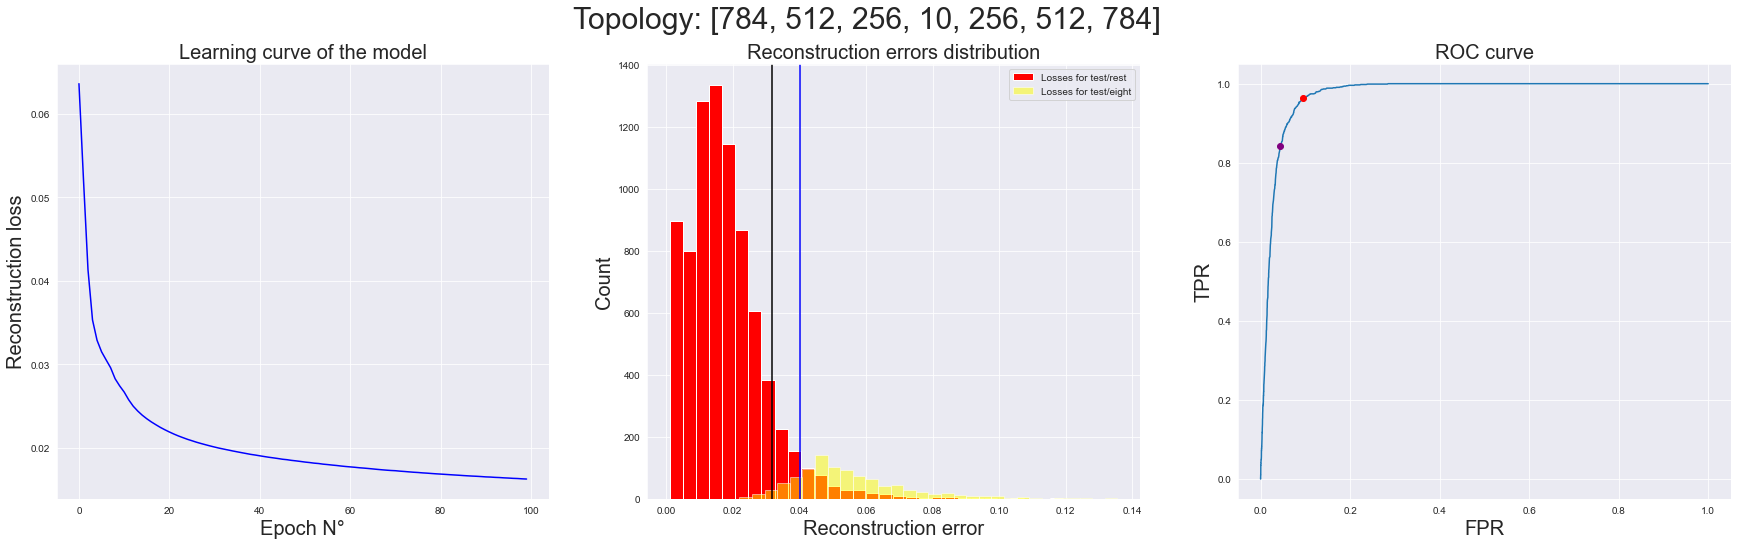

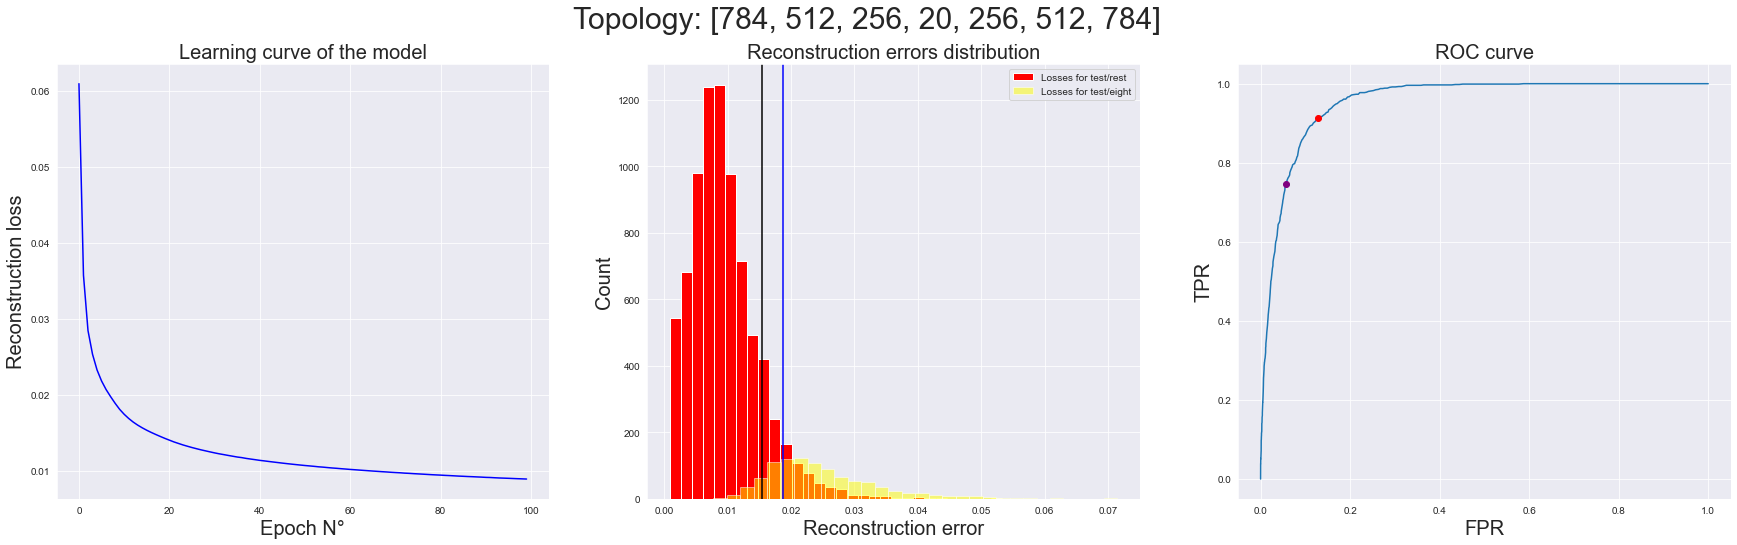

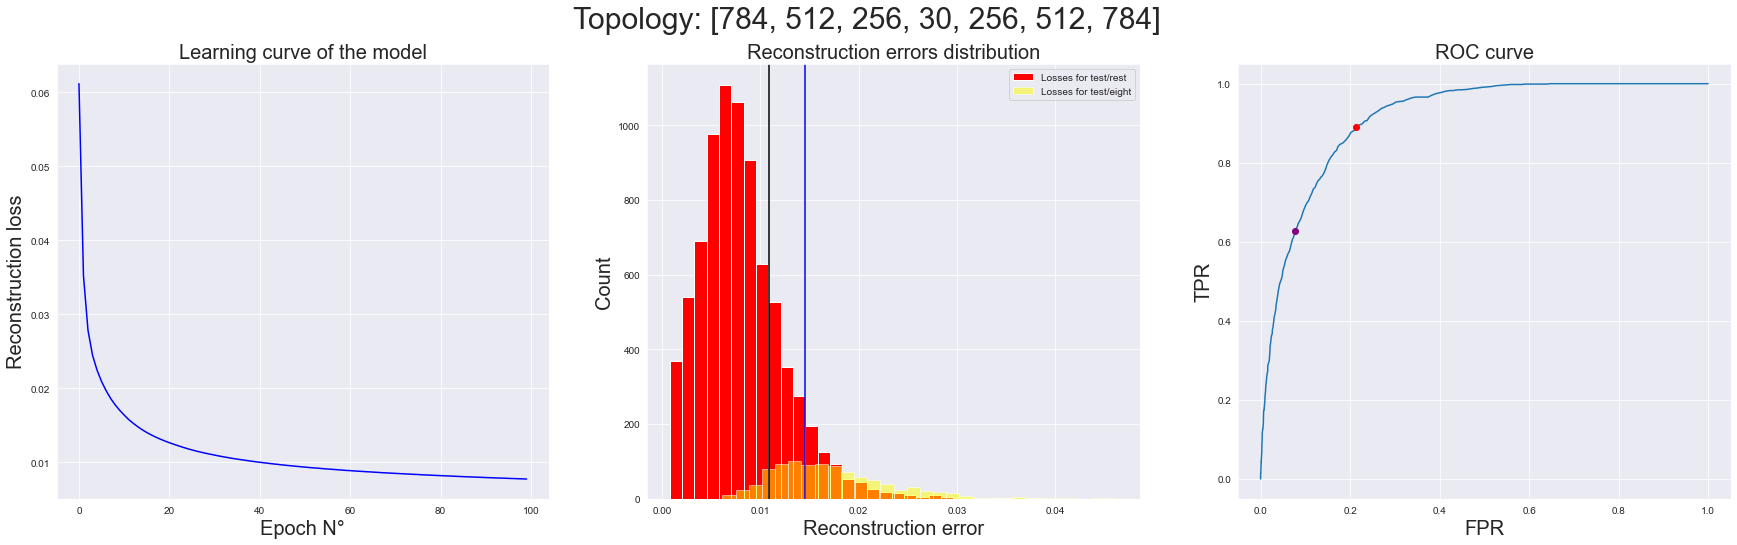

In [299]:
topologies_exp_for_bottleneck = [
    [784, 512, 256, 10, 256, 512, 784],
    [784, 512, 256, 20, 256, 512, 784],
    [784, 512, 256, 30, 256, 512, 784]
]
for i, topology in enumerate(topologies_exp_for_bottleneck):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, topology)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = topology, th, tpr, fpr, f1_score, f1_score_threshold

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.049100
Epoch 1, loss 0.029563
Epoch 2, loss 0.026418
Epoch 3, loss 0.024987
Epoch 4, loss 0.023982
Epoch 5, loss 0.023160
Epoch 6, loss 0.022534
Epoch 7, loss 0.022023
Epoch 8, loss 0.021624
Epoch 9, loss 0.021279
Epoch 10, loss 0.020950
Epoch 11, loss 0.020660
Epoch 12, loss 0.020415
Epoch 13, loss 0.020244
Epoch 14, loss 0.020028
Epoch 15, loss 0.019863
Epoch 16, loss 0.019672
Epoch 17, loss 0.019562
Epoch 18, loss 0.019412
Epoch 19, loss 0.019316
Epoch 20, loss 0.019180
Epoch 21, loss 0.019059
Epoch 22, loss 0.018976
Epoch 23, loss 0.018869
Epoch 24, loss 0.018798
Epoch 25, loss 0.018724
Epoch 26, loss 0.018623
Epoch 27, loss 0.018567
Epoch 28, loss 0.018480
Epoch 29, loss 0.018419
Epoch 30, loss 0.018358
Epoch 31, loss 0.018275
Epoch 32, loss 0.018216
Epoch 33, loss 0.018142
Epoch 34, loss 0.018095
Epoch 35, loss 0.018049
Epoch 36, loss 0.018029
Epoch 37, loss 0.017955
Epoch 38, loss 0.017929
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.035

Anomalies in EIGHT: 94.35 %
Anomalies in REST: 10.27 %

Threshold maximizing f1-score:  0.042

Anomalies in EIGHT: 85.32 %
Anomalies in REST: 5.99 %
Best f1 score: 0.7267162221250547

AUC-ROC: 0.9656048560433018
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.061145
Epoch 1, loss 0.035596
Epoch 2, loss 0.028924
Epoch 3, loss 0.026510
Epoch 4, loss 0.024525
Epoch 5, loss 0.023032
Epoch 6, loss 0.022004
Epoch 7, loss 0.021220
Epoch 8, loss 0.020588
Epoch 9, loss 0.020059
Epoch 10, loss 0.019610
Epoch 11, loss 0.019203
Epoch 12, loss 0.018840
Epoch 13, loss 0.018517
Epoch 14, loss 0.018210
Epoch 15, loss 0.017935
Epoch 16, loss 0.017690
Epoch 17, loss 0.017444
Epoch 18, loss 0.017233
Epoch 19, loss 0.017018
Epoch 20, loss 0.016828
Epoch 21, loss 0.016652
Epoch 22, loss 0.016490
Epoch 23, loss 0.016326
Epoch 24, loss 0.016171
Epoch 25, loss 0.016030
Epoch 26, loss 0.015897
Epoch 27, loss 0.015767
Epoch 28, loss 0.0156

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:27: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)



With max(tpr-fpr) threshold:  0.023

Anomalies in EIGHT: 96.2 %
Anomalies in REST: 9.98 %

Threshold maximizing f1-score:  0.03

Anomalies in EIGHT: 78.75 %
Anomalies in REST: 3.64 %
Best f1 score: 0.7541789577187809

AUC-ROC: 0.9734950457289834
Experiment N° 3
--------------------------------------------------
Epoch 0, loss 0.083542
Epoch 1, loss 0.063327
Epoch 2, loss 0.056485
Epoch 3, loss 0.046801
Epoch 4, loss 0.041395
Epoch 5, loss 0.038674
Epoch 6, loss 0.036833
Epoch 7, loss 0.035044
Epoch 8, loss 0.033614
Epoch 9, loss 0.032374
Epoch 10, loss 0.031279
Epoch 11, loss 0.030424
Epoch 12, loss 0.029679
Epoch 13, loss 0.028990
Epoch 14, loss 0.028368
Epoch 15, loss 0.027801
Epoch 16, loss 0.027303
Epoch 17, loss 0.026861
Epoch 18, loss 0.026461
Epoch 19, loss 0.026087
Epoch 20, loss 0.025739
Epoch 21, loss 0.025414
Epoch 22, loss 0.025118
Epoch 23, loss 0.024846
Epoch 24, loss 0.024598
Epoch 25, loss 0.024363
Epoch 26, loss 0.024146
Epoch 27, loss 0.023948
Epoch 28, loss 0.023756


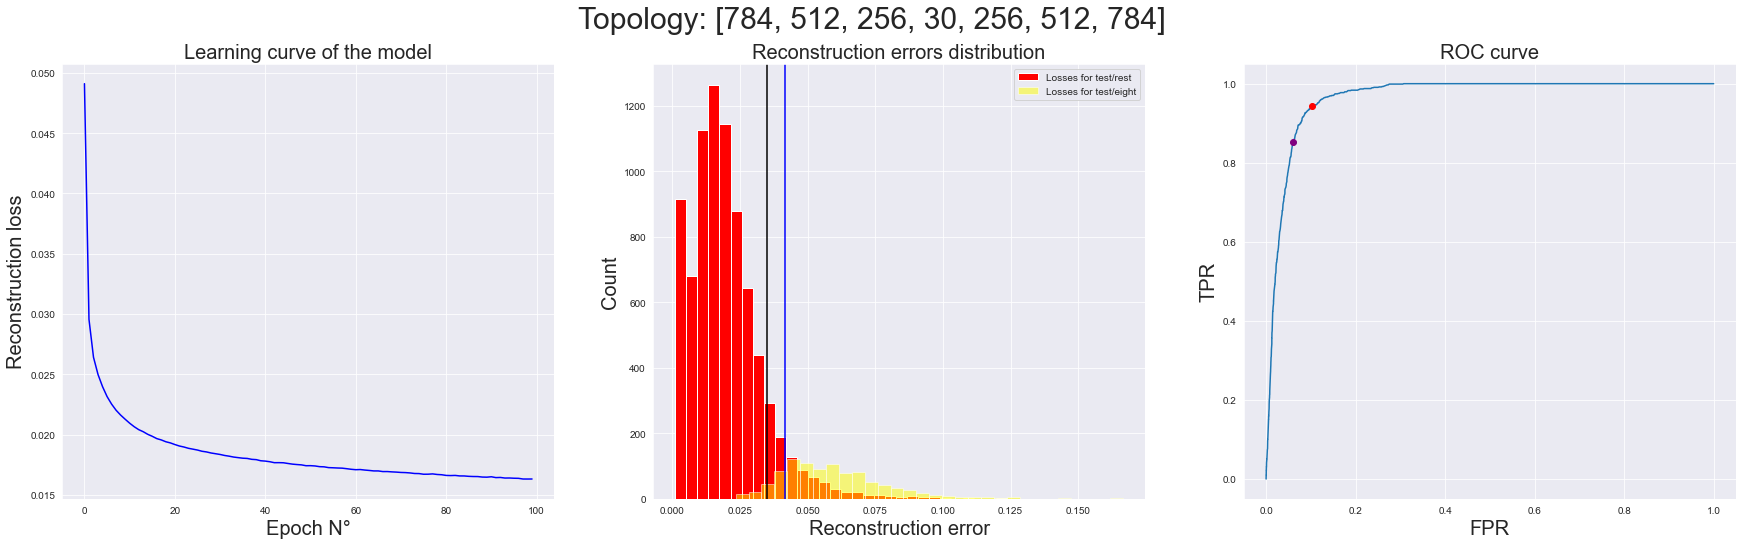

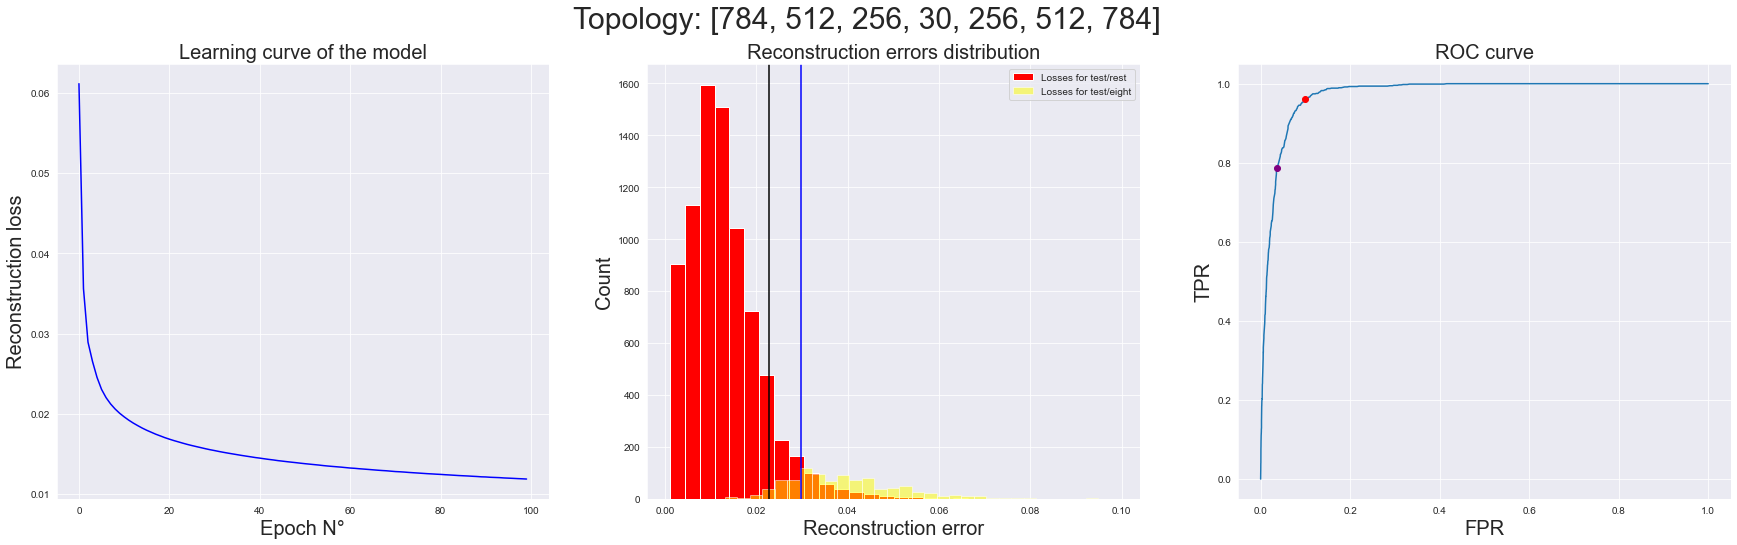

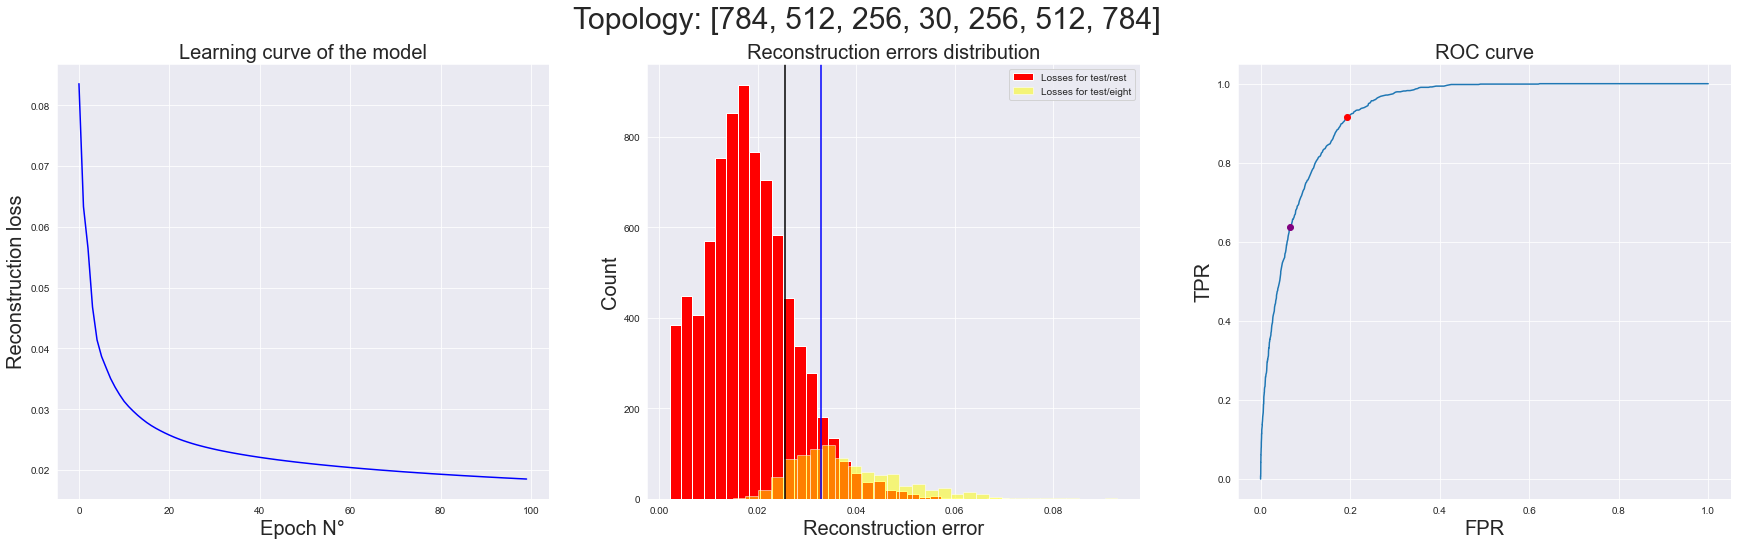

In [301]:
learning_rates = [0.001, 0.0001, 0.00001]
best_lr = 0.0001 # default value used until now
for i, lr in enumerate(learning_rates):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, best_top, lr=lr)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = best_top, th, tpr, fpr, f1_score, f1_score_threshold
        best_lr = lr

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.050103
Epoch 1, loss 0.030555
Epoch 2, loss 0.027406
Epoch 3, loss 0.025118
Epoch 4, loss 0.023698
Epoch 5, loss 0.022703
Epoch 6, loss 0.021962
Epoch 7, loss 0.021380
Epoch 8, loss 0.020885
Epoch 9, loss 0.020470
Epoch 10, loss 0.020116
Epoch 11, loss 0.019774
Epoch 12, loss 0.019479
Epoch 13, loss 0.019205
Epoch 14, loss 0.018960
Epoch 15, loss 0.018740
Epoch 16, loss 0.018516
Epoch 17, loss 0.018323
Epoch 18, loss 0.018142
Epoch 19, loss 0.017962
Epoch 20, loss 0.017789
Epoch 21, loss 0.017643
Epoch 22, loss 0.017485
Epoch 23, loss 0.017343
Epoch 24, loss 0.017213
Epoch 25, loss 0.017076
Epoch 26, loss 0.016950
Epoch 27, loss 0.016832
Epoch 28, loss 0.016713
Epoch 29, loss 0.016598
Epoch 30, loss 0.016490
Epoch 31, loss 0.016384
Epoch 32, loss 0.016273
Epoch 33, loss 0.016190
Epoch 34, loss 0.016090
Epoch 35, loss 0.015993
Epoch 36, loss 0.015905
Epoch 37, loss 0.015814
Epoch 38, loss 0.015733
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:27: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.028

Anomalies in EIGHT: 94.35 %
Anomalies in REST: 9.29 %

Threshold maximizing f1-score:  0.034

Anomalies in EIGHT: 84.19 %
Anomalies in REST: 4.94 %
Best f1 score: 0.7485166590597901

AUC-ROC: 0.9705007979725473
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.063187
Epoch 1, loss 0.048730
Epoch 2, loss 0.042078
Epoch 3, loss 0.039367
Epoch 4, loss 0.037615
Epoch 5, loss 0.036506
Epoch 6, loss 0.035544
Epoch 7, loss 0.033457
Epoch 8, loss 0.031913
Epoch 9, loss 0.031092
Epoch 10, loss 0.030434
Epoch 11, loss 0.029916
Epoch 12, loss 0.029462
Epoch 13, loss 0.029063
Epoch 14, loss 0.028710
Epoch 15, loss 0.028394
Epoch 16, loss 0.028103
Epoch 17, loss 0.027840
Epoch 18, loss 0.027615
Epoch 19, loss 0.027375
Epoch 20, loss 0.027164
Epoch 21, loss 0.026981
Epoch 22, loss 0.026788
Epoch 23, loss 0.026623
Epoch 24, loss 0.026460
Epoch 25, loss 0.026299
Epoch 26, loss 0.025979
Epoch 27, loss 0.025560
Epoch 28, loss 0.02516

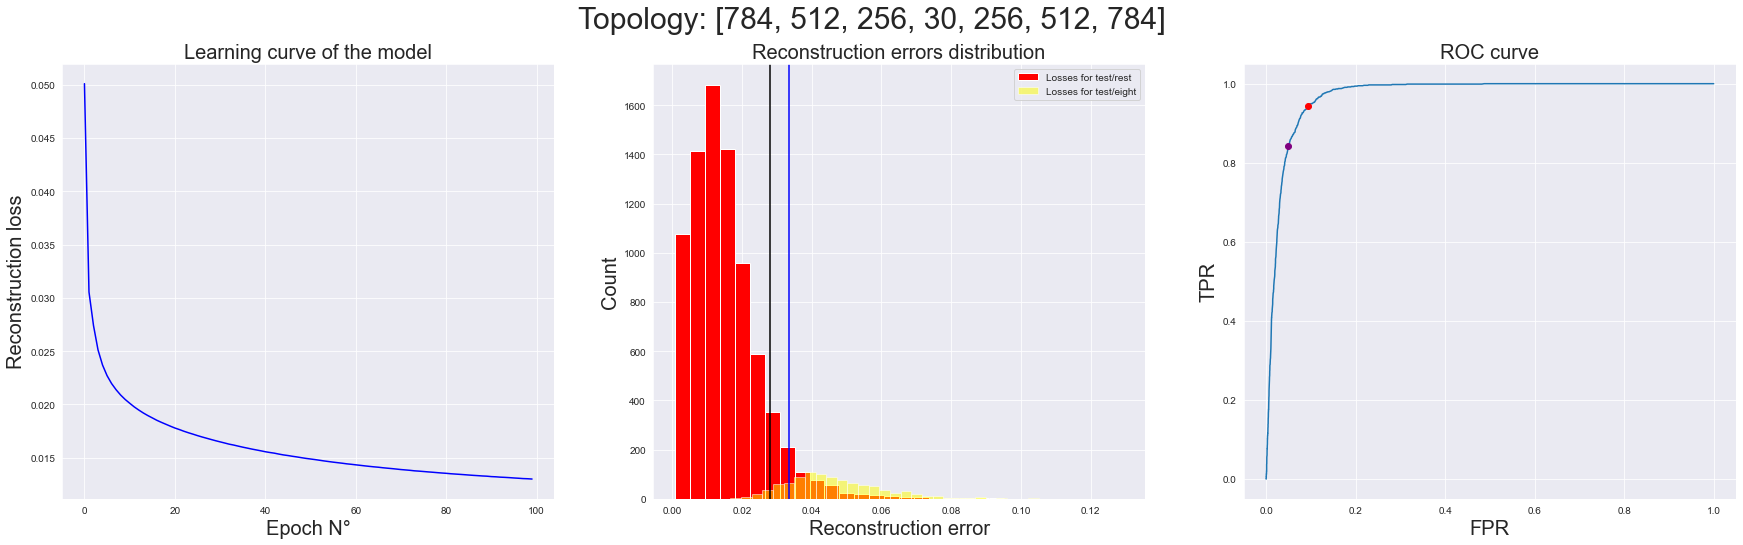

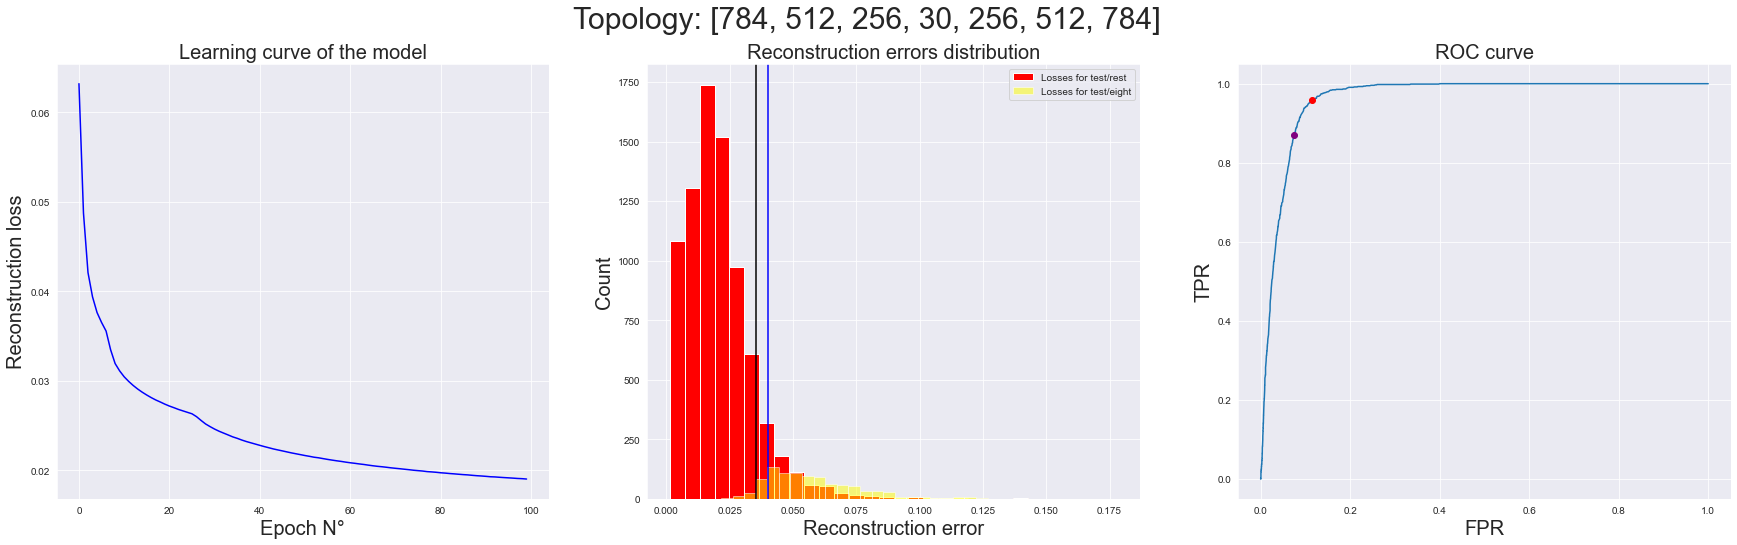

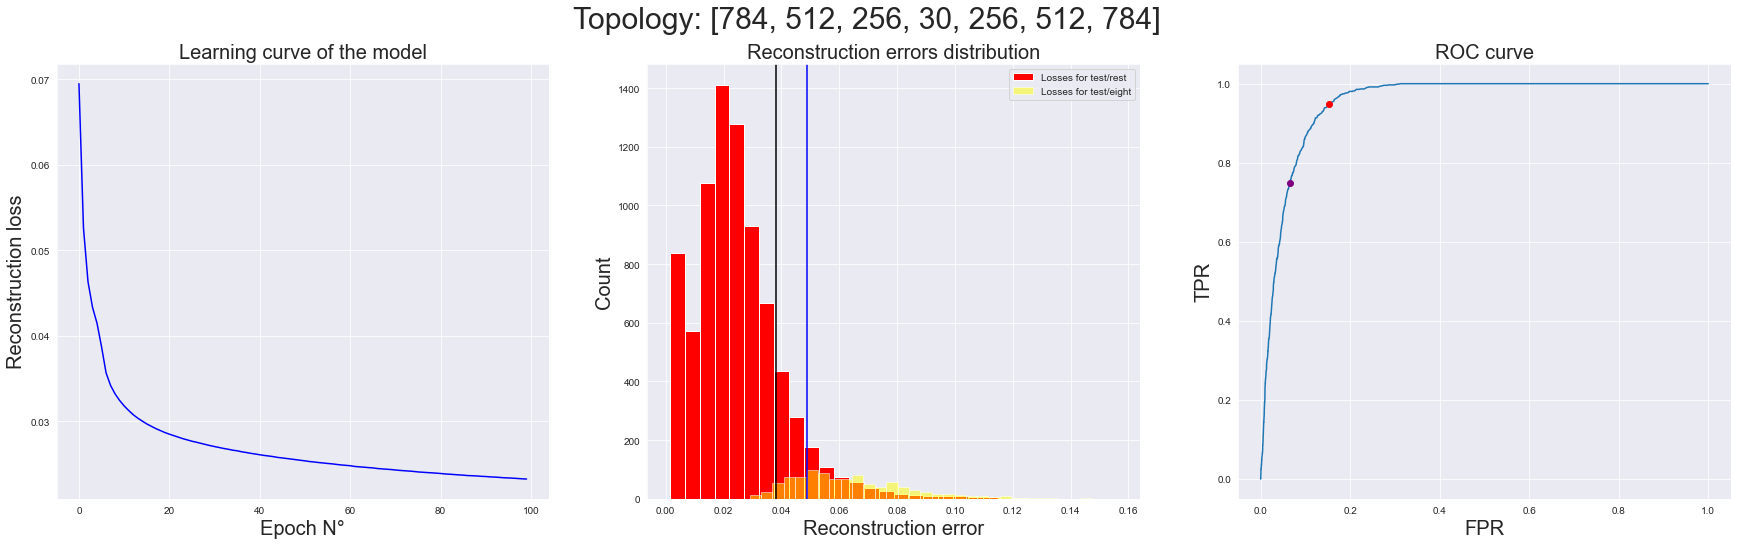

In [302]:
batches = [64, 128, 256]
best_batch = 128
for i, batch in enumerate(batches):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, best_top, lr=best_lr, batch_size=batch)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = best_top, th, tpr, fpr, f1_score, f1_score_threshold
        best_batch = batch

Experiment N° 1
--------------------------------------------------
Epoch 0, loss 0.062997
Epoch 1, loss 0.050915
Epoch 2, loss 0.043161
Epoch 3, loss 0.038402
Epoch 4, loss 0.034832
Epoch 5, loss 0.032252
Epoch 6, loss 0.030180
Epoch 7, loss 0.028955
Epoch 8, loss 0.028128
Epoch 9, loss 0.027486
Epoch 10, loss 0.026963
Epoch 11, loss 0.026501
Epoch 12, loss 0.026118
Epoch 13, loss 0.025763
Epoch 14, loss 0.025459
Epoch 15, loss 0.025166
Epoch 16, loss 0.024888
Epoch 17, loss 0.024643
Epoch 18, loss 0.024398
Epoch 19, loss 0.024183
Epoch 20, loss 0.023956
Epoch 21, loss 0.023764
Epoch 22, loss 0.023580
Epoch 23, loss 0.023394
Epoch 24, loss 0.023227
Epoch 25, loss 0.023072
Epoch 26, loss 0.022917
Epoch 27, loss 0.022773
Epoch 28, loss 0.022632
Epoch 29, loss 0.022503
Epoch 30, loss 0.022376
Epoch 31, loss 0.022254
Epoch 32, loss 0.022137
Epoch 33, loss 0.022033
Epoch 34, loss 0.021915
Epoch 35, loss 0.021815
Epoch 36, loss 0.021710
Epoch 37, loss 0.021600
Epoch 38, loss 0.021524
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.034

Anomalies in EIGHT: 96.82 %
Anomalies in REST: 12.06 %

Threshold maximizing f1-score:  0.043

Anomalies in EIGHT: 79.98 %
Anomalies in REST: 5.43 %
Best f1 score: 0.7114155251141553

AUC-ROC: 0.9648489391508919
Experiment N° 2
--------------------------------------------------
Epoch 0, loss 0.063722
Epoch 1, loss 0.051792
Epoch 2, loss 0.043200
Epoch 3, loss 0.036802
Epoch 4, loss 0.033810
Epoch 5, loss 0.032245
Epoch 6, loss 0.031229
Epoch 7, loss 0.030475
Epoch 8, loss 0.029312
Epoch 9, loss 0.028070
Epoch 10, loss 0.027337
Epoch 11, loss 0.026746
Epoch 12, loss 0.026219
Epoch 13, loss 0.025766
Epoch 14, loss 0.025362
Epoch 15, loss 0.025023
Epoch 16, loss 0.024703
Epoch 17, loss 0.024425
Epoch 18, loss 0.024165
Epoch 19, loss 0.023936
Epoch 20, loss 0.023733
Epoch 21, loss 0.023549
Epoch 22, loss 0.023349
Epoch 23, loss 0.023175
Epoch 24, loss 0.023021
Epoch 25, loss 0.022869
Epoch 26, loss 0.022721
Epoch 27, loss 0.022585
Epoch 28, loss 0.0224

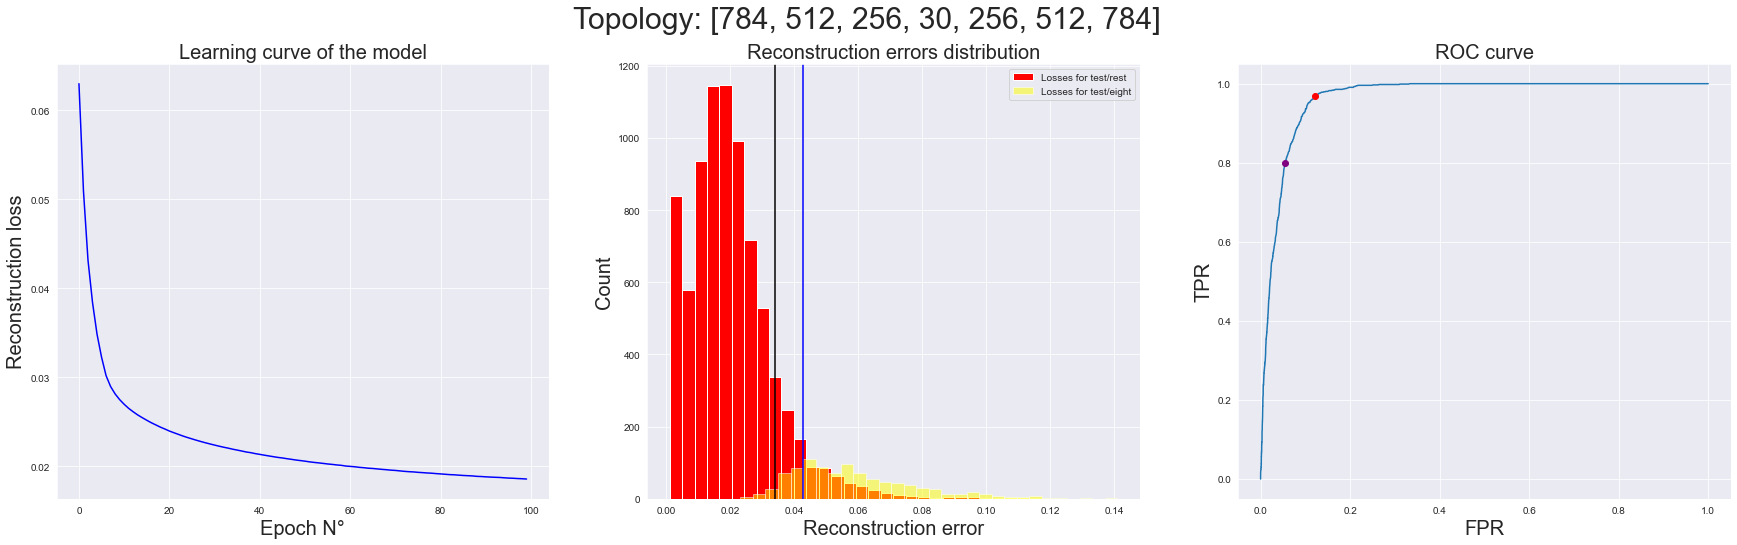

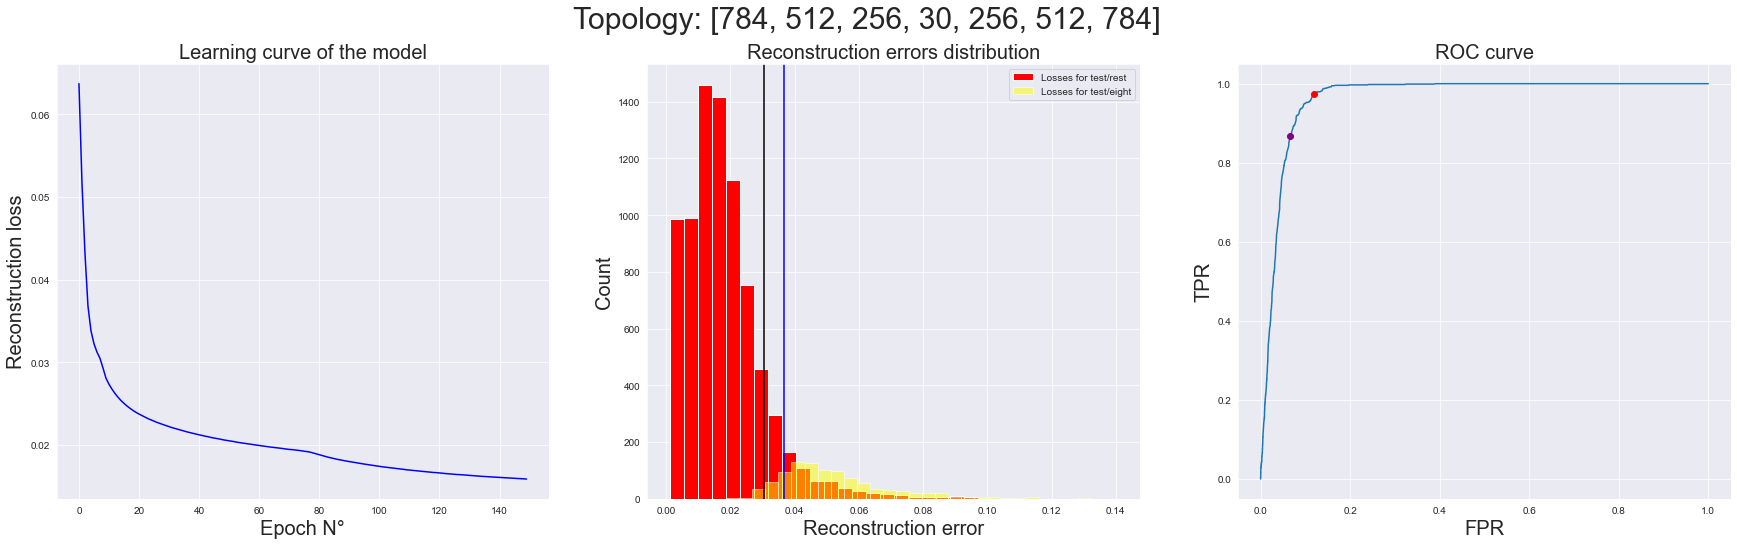

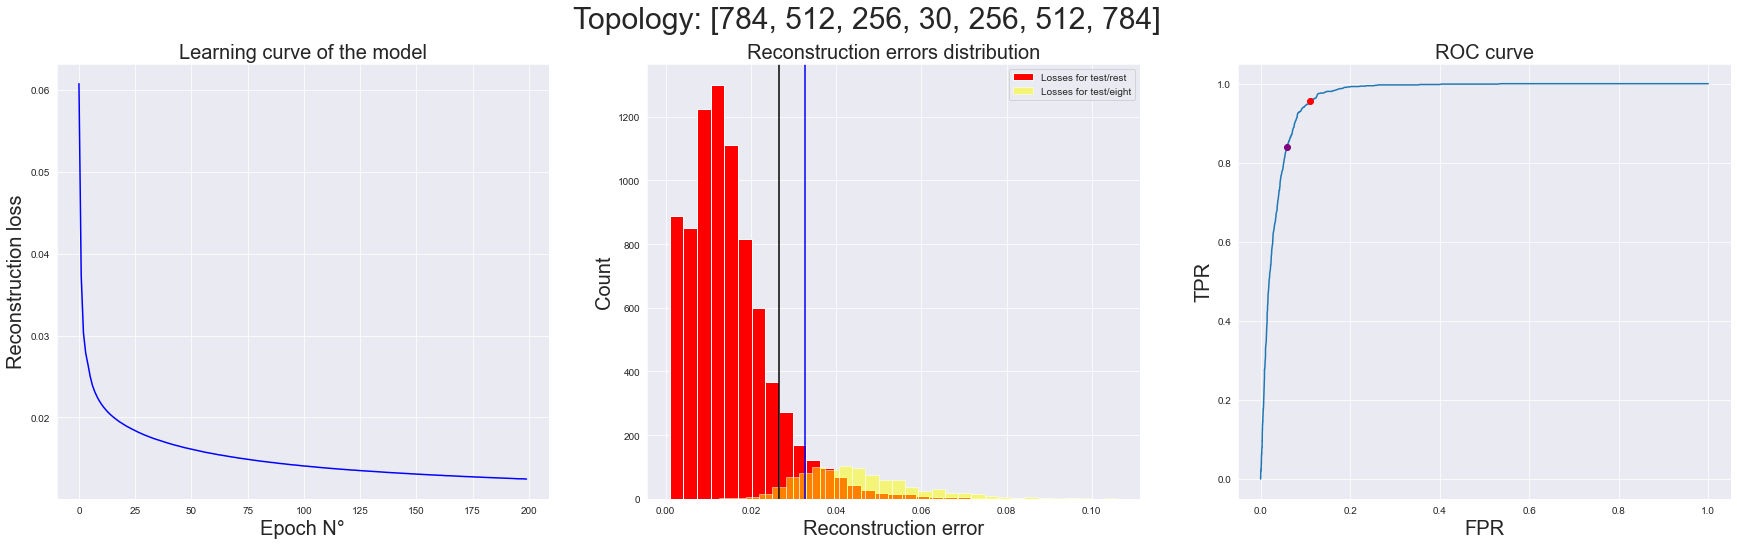

In [303]:
epochs = [100, 150, 200]
best_epochs = 100
for i, epoch in enumerate(epochs):
    model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(i+1, best_top, lr=best_lr, batch_size=best_batch, max_epochs=epoch)
    if tpr - fpr > best_tpr - best_fpr:
        best_top, best_th, best_tpr, best_fpr, best_f1_score, best_f1_score_threshold = best_top, th, tpr, fpr, f1_score, f1_score_threshold
        best_epochs = epoch

Experiment N° 0
--------------------------------------------------
Epoch 0, loss 0.051329
Epoch 1, loss 0.030989
Epoch 2, loss 0.027549
Epoch 3, loss 0.025857
Epoch 4, loss 0.024164
Epoch 5, loss 0.022941
Epoch 6, loss 0.022132
Epoch 7, loss 0.021487
Epoch 8, loss 0.020955
Epoch 9, loss 0.020495
Epoch 10, loss 0.020083
Epoch 11, loss 0.019731
Epoch 12, loss 0.019422
Epoch 13, loss 0.019144
Epoch 14, loss 0.018869
Epoch 15, loss 0.018637
Epoch 16, loss 0.018406
Epoch 17, loss 0.018211
Epoch 18, loss 0.018019
Epoch 19, loss 0.017828
Epoch 20, loss 0.017658
Epoch 21, loss 0.017499
Epoch 22, loss 0.017348
Epoch 23, loss 0.017204
Epoch 24, loss 0.017064
Epoch 25, loss 0.016932
Epoch 26, loss 0.016805
Epoch 27, loss 0.016682
Epoch 28, loss 0.016565
Epoch 29, loss 0.016467
Epoch 30, loss 0.016347
Epoch 31, loss 0.016246
Epoch 32, loss 0.016145
Epoch 33, loss 0.016043
Epoch 34, loss 0.015955
Epoch 35, loss 0.015866
Epoch 36, loss 0.015785
Epoch 37, loss 0.015701
Epoch 38, loss 0.015613
Epoch 3

C:\Users\georg\AppData\Local\Temp/ipykernel_32/2178499698.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)



With max(tpr-fpr) threshold:  0.027

Anomalies in EIGHT: 96.41 %
Anomalies in REST: 9.76 %

Threshold maximizing f1-score:  0.034

Anomalies in EIGHT: 85.83 %
Anomalies in REST: 5.23 %
Best f1 score: 0.7494397131331242

AUC-ROC: 0.9726111111678378


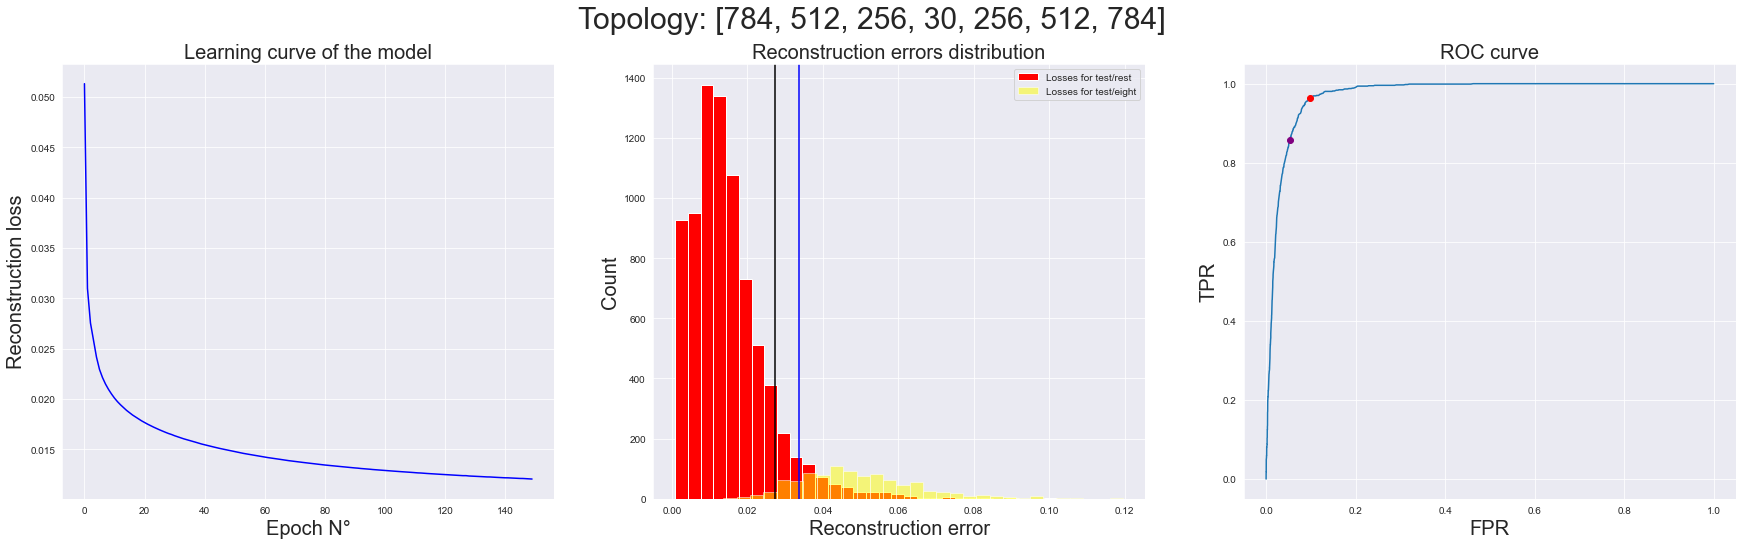

In [338]:
#torch.save(model, 'best_model.pth')
best_model, th, tpr, fpr, f1_score, f1_score_threshold = experiment(000, [784, 512, 256, 10, 256, 512, 784], 64, 150, 0.0001)

In [340]:
def plot_comparison(dec_normal, dec_eight, dec_four):

    random_idx_1 = randint(0, dec_normal.shape[0])
    random_idx_2 = randint(0, dec_eight.shape[0])
    random_idx_3 = randint(0, dec_four.shape[0])
    og_images = [x_test_normal[random_idx_1], x_test_eight[random_idx_2], x_test_four[random_idx_3]]
    dec_images = [dec_normal[random_idx_1], dec_eight[random_idx_2], dec_four[random_idx_3]]

    F, X = plt.subplots(nrows=2, ncols=3, figsize=(7, 5))
    F.suptitle('Comparison in reconstruction normal/4/8', fontsize=16)

    for i, image in enumerate(og_images):
        plot_single_digit(X[0, i], image)
        X[0, i].set_title('Original')
        X[0, i].axis('off')

    for i, image in enumerate(dec_images):
        plot_single_digit(X[1, i], image)
        X[1, i].set_title('Decoded')
        X[1, i].axis('off')

In [345]:
test_mse_normal, test_dec_data_normal = eval_ae_model(torch.tensor(x_test_normal),best_model)
test_mse_eight, test_dec_data_eight = eval_ae_model(torch.tensor(x_test_eight),best_model)
test_mse_four, test_dec_data_four = eval_ae_model(torch.tensor(x_test_four),best_model)
print('MSE Test/normal:\t: ', test_mse_normal)
print('MSE Test/4:\t: ', test_mse_four)

MSE Test/Rest:	:  tensor(0.0149)
MSE Test/4:	:  tensor(0.0418, grad_fn=<MseLossBackward0>)


C:\Users\georg\AppData\Local\Temp/ipykernel_32/4006781043.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('MSE Test/Rest:\t: ', torch.tensor(test_mse_rest))


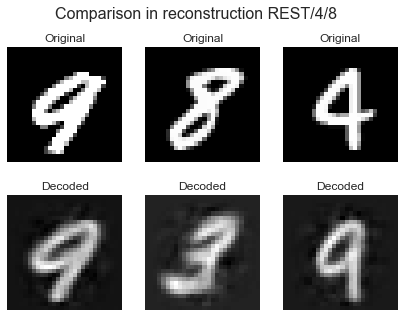

In [343]:
plot_comparison(test_dec_data_normal, test_dec_data_eight, test_dec_data_four)

In [339]:
evaluate_model(best_model, th) # using max(TPR-FPR) threshold
evaluate_model(best_model, f1_score_threshold) # using max(f1-score) threshold

Anomalies in FOUR: 78 %
Anomalies in FOUR: 59 %


In [346]:
save_model(best_model, [784, 512, 256, 10, 256, 512, 784], 64, 150, 0.01491, 0.049692, 0.9641, 0.0976, 0.9726, 0.027)